[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mortgad/DLVR/blob/main/FilteredData.ipynb)

# Baseline model

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow import keras, layers
conv_base = ResNet50V2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
conv_base.trainable = False  # Freeze the pre-trained layers
inputs = keras.Input(shape=(224, 224, 3))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

# Baseline with downsampling

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# save_model_path = '/content/drive/MyDrive/DL for VR/Project/Models' # Thomas
save_model_path = '/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/' # Morten
#save_model_path = '/content/drive/MyDrive/Visual reg' # Mads

!git clone https://github.com/mortgad/DLVR.git
%cd DLVR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'DLVR'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 482 (delta 81), reused 74 (delta 70), pack-reused 384 (from 1)
Receiving objects: 100% (482/482), 56.68 MiB | 38.51 MiB/s, done.
Resolving deltas: 100% (267/267), done.
/content/DLVR


In [ ]:
n_samples = 3632 # Number of images in the filtered dataset

from utils.utkface import load_utkface
load_utkface()

from utils.utkface import preprocess_utkface
df_utkface, df_utkface_raw = preprocess_utkface()

df = df_utkface_raw[['age_raw','gender_code','race_code','file']]

df = df[df['age_raw']<=100]

df.rename(columns={'age_raw': 'age_code'}, inplace=True)

# Sample rows
df = df.sample(n=n_samples, random_state=123)

# Display
df.head()

In [ ]:
from utils.preprocessing import create_lists

images, ages, races, genders = create_lists(df)

# Baseline with filtered data

In [ ]:
import os
base_dir = '/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project'
folder_name = 'UTKFace_Filtered'
metadata_file = 'UTKFace_Filtered_Metadata.csv'
filtered_images_dir = os.path.join(base_dir, folder_name)

# Load csv-file
import pandas as pd
df = pd.read_csv(os.path.join(base_dir, metadata_file))

# Preprocess df
df = df[['age_raw','gender_code','race_code','file']]
df = df[df['age_raw']<=100]
df.rename(columns={'age_raw': 'age_code'}, inplace=True)

# Fix paths
df['file'] = df['file'].apply(lambda x: os.path.join(filtered_images_dir, x))

# Display
df.head()

,age_code,gender_code,race_code,file
0,22,1,3,/content/drive/MyDrive/Deep_Learning_Visual_Re...
1,39,0,4,/content/drive/MyDrive/Deep_Learning_Visual_Re...
2,75,0,0,/content/drive/MyDrive/Deep_Learning_Visual_Re...
3,3,1,4,/content/drive/MyDrive/Deep_Learning_Visual_Re...
4,39,0,0,/content/drive/MyDrive/Deep_Learning_Visual_Re...


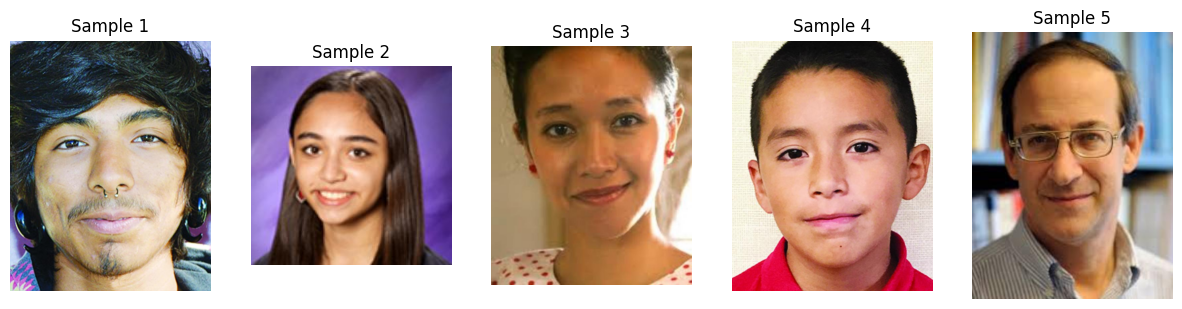

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_sample_images_from_paths(df, num_samples=5):
    # Ensure num_samples does not exceed the number of available files
    num_samples = min(num_samples, len(df))

    # Randomly select file paths from the DataFrame
    sample_paths = df['file'].sample(num_samples).values

    # Set up the plot dimensions
    plt.figure(figsize=(15, 5))

    for i, file_path in enumerate(sample_paths):
        try:
            # Open each image file
            img = Image.open(file_path)

            # Display the image in the subplot
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Sample {i+1}")

        except FileNotFoundError:
            print(f"File not found at path: {file_path}")

    # Show the plot with all images
    plt.show()

# Call the function with the DataFrame and desired number of samples
plot_sample_images_from_paths(df, num_samples=5)

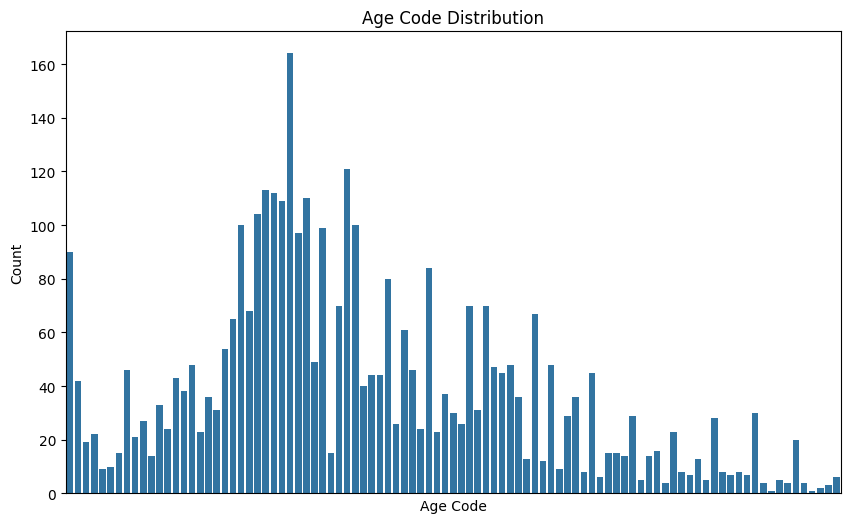

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='age_code', data=df)
plt.title('Age Code Distribution')
# Remove x-axis labels
plt.xticks([])
plt.xlabel('Age Code')
plt.ylabel('Count')
plt.show()

In [ ]:
!git clone https://github.com/mortgad/DLVR.git
%cd DLVR

Cloning into 'DLVR'...
remote: Enumerating objects: 446, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 446 (delta 180), reused 174 (delta 100), pack-reused 142 (from 1)
Receiving objects: 100% (446/446), 55.55 MiB | 17.56 MiB/s, done.
Resolving deltas: 100% (242/242), done.
/content/DLVR


In [ ]:
from utils.preprocessing import create_lists
# df_first_100 = df.head(100)
df_copy = df.copy()

# Create lists
images, ages, races, genders = create_lists(df_copy)
print(f"Loaded {len(images)} images.")

Processing images:   0%|          | 0/3632 [00:00<?, ?it/s]

Loaded 3632 images.


In [ ]:
# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))
print(f"Number of age classes: {num_classes_age}")
print(f"Number of gender classes: {num_classes_gender}")
print(f"Number of ethnicity classes: {num_classes_ethnicity}")

Number of age classes: 95
Number of gender classes: 2
Number of ethnicity classes: 5


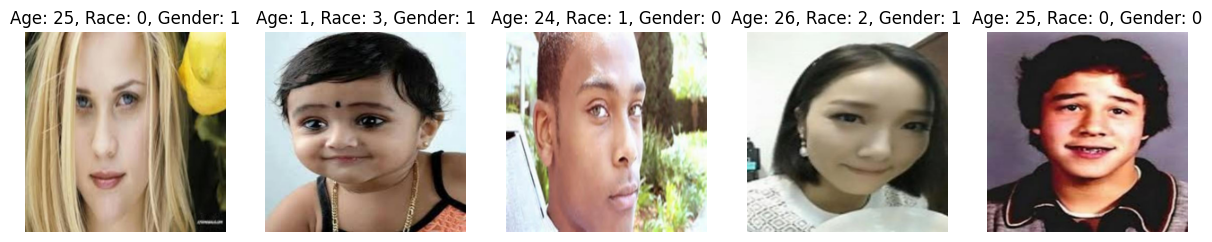

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(images, ages, races, genders, num_samples=5):
    # Ensure that num_samples is not greater than the available images
    num_samples = min(num_samples, len(images))

    # Randomly select indices to sample from the images
    random_indices = np.random.choice(len(images), num_samples, replace=False)

    # Set up the plot dimensions (e.g., 5 images in a single row)
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_samples, i + 1)

        # Plot each image
        plt.imshow(images[idx])

        # Show age, race, and gender as the title
        plt.title(f"Age: {ages[idx]}, Race: {races[idx]}, Gender: {genders[idx]}")

        # Remove axis ticks for a cleaner look
        plt.axis('off')

    # Display the plot
    plt.show()

# Call the function with the images, ages, races, and genders arrays
plot_sample_images(images, ages, races, genders, num_samples=5)

In [ ]:
import numpy as np

# Get unique ages and their counts
unique, counts = np.unique(ages, return_counts=True)

# Find ages with a count of 1 or lower
rare_ages = unique[counts <= 1]

# Print or return the result
print("Ages with count of 1 or lower:", rare_ages)

# Get indices of these ages and remove from all lists
indices_to_remove = np.where(np.isin(ages, rare_ages))[0]
images = np.delete(images, indices_to_remove, axis=0)
ages = np.delete(ages, indices_to_remove)
races = np.delete(races, indices_to_remove)
genders = np.delete(genders, indices_to_remove)

# Verify
unique, counts = np.unique(ages, return_counts=True)
rare_ages = unique[counts <= 1]
print("Ages with count of 1 or lower:", rare_ages)

Ages with count of 1 or lower: []
Ages with count of 1 or lower: []


In [ ]:
from sklearn.model_selection import train_test_split
from keras.applications.resnet_v2 import preprocess_input

images_preprocessed = preprocess_input(images)

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(images_preprocessed, ages, races, genders, test_size=0.20, random_state=42, stratify=ages)

# Split temp into validation (75% of temp, which is 15% of original data) and test (25% of temp, which is 5% of original data)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.25, random_state=42)


print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

Training set: (2904, 224, 224, 3), Training labels: (2904,)
Age validation set: (544, 224, 224, 3), Age validation labels: (544,)
Age test set: (182, 224, 224, 3), Age test labels: (182,)
Race validation labels: (544,)
Race test labels: (182,)
Gender validation labels: (544,)
Gender test labels: (182,)


In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

outputs = layers.Dense(1, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)
model.compile(loss="mean_squared_error",
              optimizer=optimizer,
              metrics=["mae"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
model_name = 'baseline_filtered_images.keras'
file_path = os.path.join(base_dir, model_name)
print(f'Callback path: {file_path}')

Callback path: /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/baseline_filtered_images.keras


In [ ]:
# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path,
                             monitor='val_mae',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

# Train the model
history = model.fit(
    X_train,
    y_train_age,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/40
91/91 [==============================] - ETA: 0s - loss: 1626.7971 - mae: 35.8231
Epoch 1: val_mae improved from inf to 35.93105, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/baseline_filtered_images.keras
91/91 [==============================] - 49s 492ms/step - loss: 1626.7971 - mae: 35.8231 - val_loss: 1600.3525 - val_mae: 35.9310
Epoch 2/40
91/91 [==============================] - ETA: 0s - loss: 1262.7592 - mae: 31.9856
Epoch 2: val_mae improved from 35.93105 to 29.95555, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/baseline_filtered_images.keras
91/91 [==============================] - 43s 477ms/step - loss: 1262.7592 - mae: 31.9856 - val_loss: 1075.0635 - val_mae: 29.9555
Epoch 3/40
91/91 [==============================] - ETA: 0s - loss: 819.2966 - mae: 25.3402
Epoch 3: val_mae improved from 29.95555 to 21.74766, saving model to /content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/baseli

Best Training MAE: 4.1337
Best Validation MAE: 7.4261
Best Training Loss: 28.6370
Best Validation Loss: 99.3829


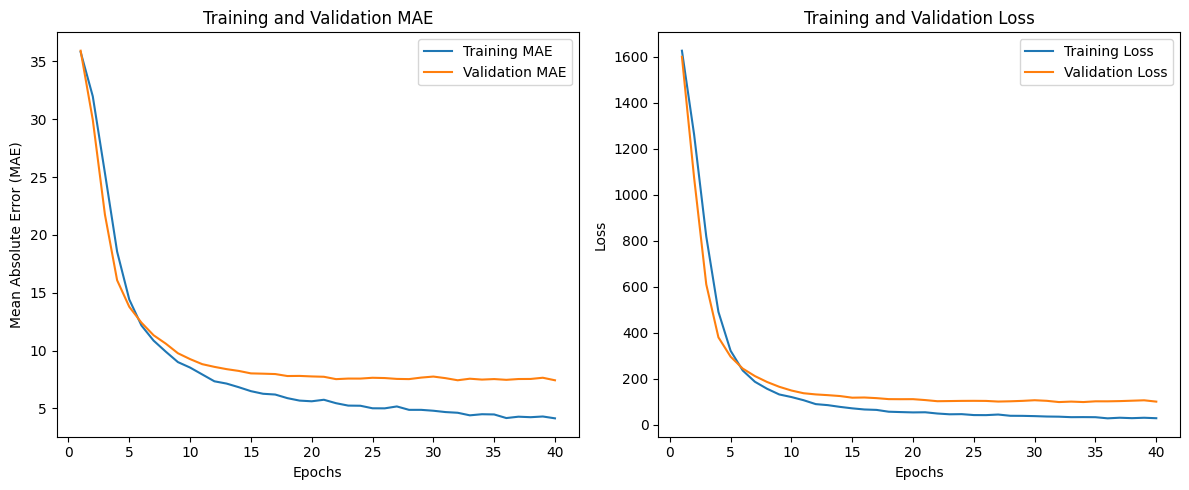

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression
evaluate_and_plot_regression(history)